# Machine Learning for Regression
House price prediction

## Dataset

Dataset is the California Housing Prices from [Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices).

Here's a wget-able [link](https://github.com/Ksyula/ML_Engineering/blob/master/02-regression/housing.csv):

```bash
wget https://raw.githubusercontent.com/Ksyula/ML_Engineering/master/02-regression/housing.csv
```

The goal is to create a regression model for predicting housing prices (column `'median_house_value'`).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
np.__version__, pd.__version__

('1.21.5', '1.4.3')

## Data preparation

In [3]:
data = pd.read_csv('housing.csv')
data.shape

(20640, 10)

In [4]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
data.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

In [6]:
data.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

<AxesSubplot:xlabel='median_house_value', ylabel='Count'>

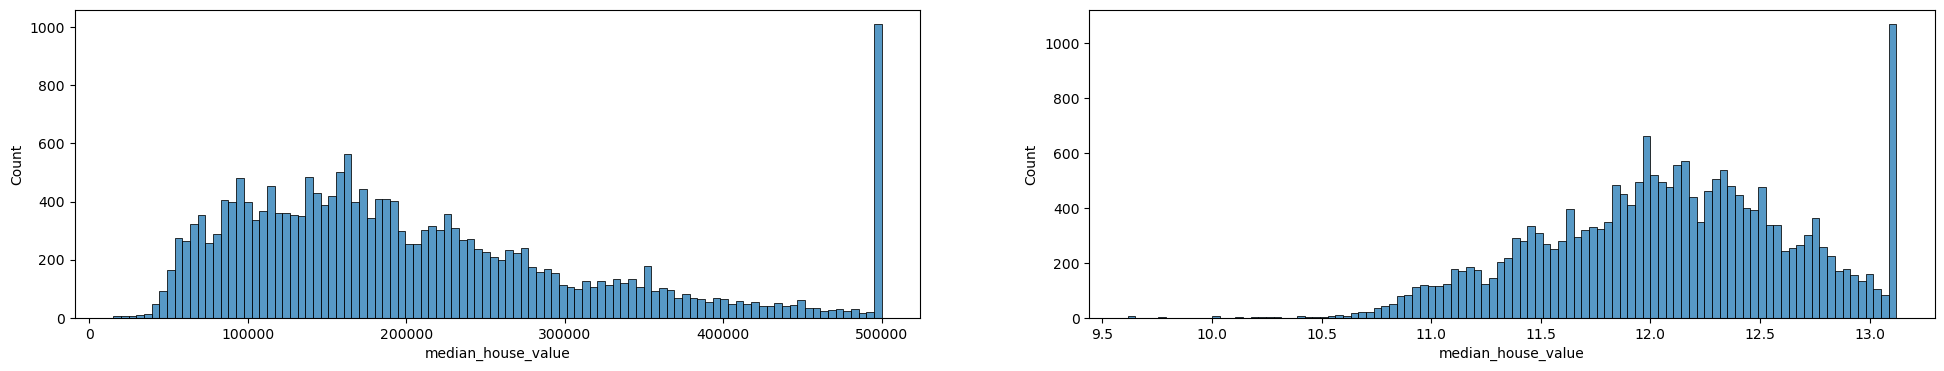

In [7]:
fig, ax = plt.subplots(1,2, figsize=(24, 4))
sns.histplot(data.median_house_value, bins = 100, ax=ax[0])
sns.histplot(np.log1p(data.median_house_value), bins = 100, ax=ax[1]) # log scale

In [8]:
cols = ['latitude','longitude','housing_median_age','total_rooms','total_bedrooms','population','households','median_income','median_house_value']
set(data.columns) - set(cols)

{'ocean_proximity'}

## Exploratory data analysis

### Question 1
Find a feature with missing values. How many missing values does it have?
- **207**
- 208
- 307
- 308

In [9]:
data.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

### Question 2

What's the median (50% percentile) for variable 'population'?
- 1133
- 1122
- **1166**
- 1188

In [10]:
np.median(data.population)

1166.0

In [11]:
data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


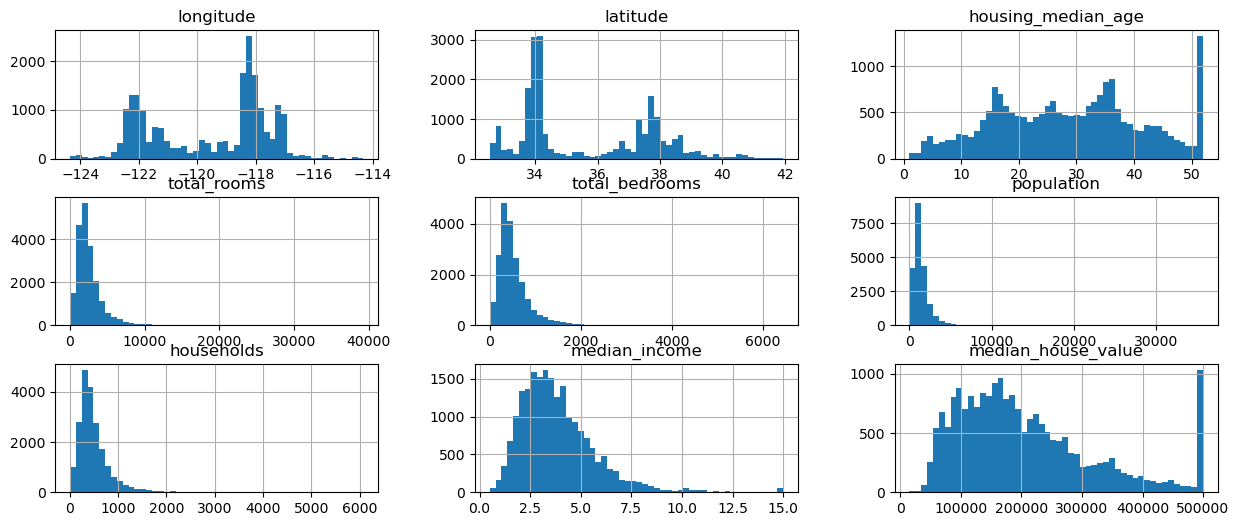

In [12]:
data.hist(figsize=(15, 6), bins=50)
plt.show()

## Setting Up The Validation Framework
### Split the data

In [13]:
def shuffle_dataset(random_seed, data):
    n = len(data)
    np.random.seed(random_seed)
    idx = np.arange(n)
    np.random.shuffle(idx)
    
    data_shuffled = data.iloc[idx].reset_index(drop=True)
    return data_shuffled

def split_data(data, n_val_perc, n_test_perc):
    n = len(data)
    n_val = int(n * n_val_perc)
    n_test = int(n * n_test_perc)
    n_train = n - n_val - n_test
    
    df_train = data.iloc[:n_train]
    df_val = data.iloc[n_train:n_train + n_val]
    df_test = data.iloc[n_train + n_val:]
    
    return df_train, df_val, df_test

def remove_target_from_train(df_train, df_val, df_test, target_name):
    y_train = df_train[target_name]
    y_val = df_val[target_name]
    y_test = df_test[target_name]
    
    y_train = np.log1p(y_train)
    y_val = np.log1p(y_val)
    y_test = np.log1p(y_test)

    del df_train[target_name]
    del df_val[target_name]
    del df_test[target_name]
    
    return df_train, df_val, df_test, y_train, y_val, y_test

In [14]:
cols = ['latitude','longitude','housing_median_age','total_rooms','total_bedrooms','population','households','median_income','median_house_value']

def prepare_data(data, random_seed, n_val_share, n_test_share):
    # Take only necessary features:
    data = data[cols]
    # Shuffle the initial dataset, use seed `42`.
    data = shuffle_dataset(random_seed, data)
    # Split data in train/val/test sets, with 60%/20%/20% distribution.
    df_train, df_val, df_test = split_data(data, n_val_share, n_test_share)
    # exclude target value ('median_house_value') from the dataframe.
    # Apply the log transformation to the target
    df_train, df_val, df_test, y_train, y_val, y_test = remove_target_from_train(df_train, df_val, df_test, 'median_house_value')
    return df_train, df_val, df_test, y_train, y_val, y_test

df_train, df_val, df_test, y_train, y_val, y_test = prepare_data(data, 42, 0.2, 0.2)

len(df_train), len(df_val), len(df_test), len(y_train), len(y_val), len(y_test)
    

(12384, 4128, 4128, 12384, 4128, 4128)

## Training Linear Regression Model
### Question 3
* We need to deal with missing values for the column from Q1.
* We have two options: fill it with 0 or with the mean of this variable.
* Try both options. For each, train a linear regression model without regularization using the code from the lessons.
* For computing the mean, use the training only!
* Use the validation dataset to evaluate the models and compare the RMSE of each option.
* Round the RMSE scores to 2 decimal digits using `round(score, 2)`
* Which option gives better RMSE?

Options:
- With 0
- With mean
- With median
- **Both are equally good**

In [15]:
def fill_missings(data, value = 0, cols = 'total_bedrooms'):
    data = data.copy()
    data[cols] = data[cols].fillna(value) 
    return data

def train_linear_regression(X, y, strategy):
    # fill missings
    if strategy == 'zero':
        X = fill_missings(X)
    elif strategy == 'mean':
        X = fill_missings(X, np.mean(X.total_bedrooms))
    # transform input data
    X, y = np.array(X), np.array(y)
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    # train LR
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full

def apply_the_model(X, w):
    # transform input data
    X = np.array(X)
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    # make predictions
    y_pred = X.dot(w)
    
    return y_pred

def rmse(y_pred, y_true):
    assert(len(y_pred) == len(y_true))
    error = y_pred - y_true
    se = error ** 2
    mse = np.mean(se)
    rmse = np.sqrt(mse)
    
    return rmse

In [16]:
zero_model = train_linear_regression(df_train, y_train, 'zero')
mean_model = train_linear_regression(df_train, y_train, 'mean')

df_val = fill_missings(df_val)
zero_y_pred = apply_the_model(df_val, zero_model)

df_val = fill_missings(df_val, np.mean(df_val.total_bedrooms))
mean_y_pred = apply_the_model(df_val, mean_model)

print("Zero strategy RMSE: ", round(rmse(zero_y_pred, y_val), 2), 
      "\nMean strategy RMSE: ", round(rmse(mean_y_pred, y_val), 2))

Zero strategy RMSE:  0.33 
Mean strategy RMSE:  0.33


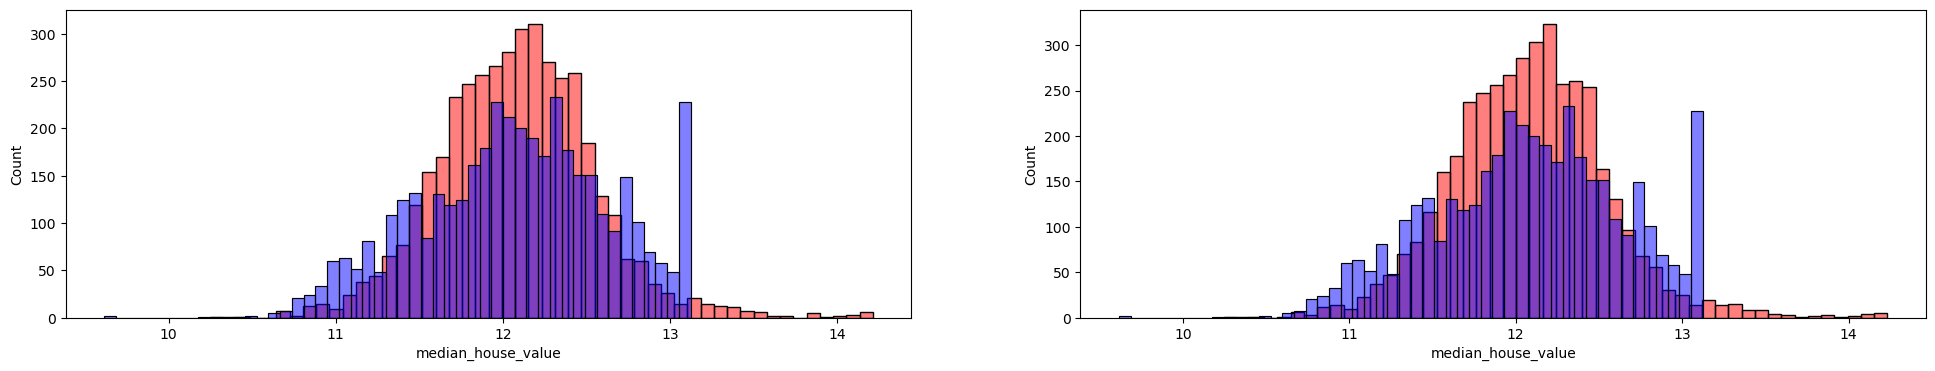

In [17]:
fig, ax = plt.subplots(1,2, figsize=(24, 4))
sns.histplot(zero_y_pred, color='red', alpha=0.5, bins=50, ax=ax[0])
sns.histplot(y_val, color='blue', alpha=0.5, bins=50, ax=ax[0])
sns.histplot(mean_y_pred, color='red', alpha=0.5, bins=50, ax=ax[1])
sns.histplot(y_val, color='blue', alpha=0.5, bins=50, ax=ax[1])
plt.show()

## Tuning Linear Regression With Regularization
### Question 4

* Now let's train a regularized linear regression.
* For this question, fill the NAs with 0. 
* Try different values of `r` from this list: `[0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]`.
* Use RMSE to evaluate the model on the validation dataset.
* Round the RMSE scores to 2 decimal digits.
* Which `r` gives the best RMSE?

If there are multiple options, select the smallest `r`.

Options:
- **0**
- 0.000001
- 0.001
- 0.01

In [18]:
def train_linear_regression_w_reg(X, y, r, strategy = 'zero'):
    # fill missings
    if strategy == 'zero':
        X = fill_missings(X)
    elif strategy == 'mean':
        X = fill_missings(X, np.mean(X['total_bedrooms']))
    # transform input data
    X, y = np.array(X), np.array(y)
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    # train LR
    XTX = X.T.dot(X)
    # add redularization
    XTX = XTX + r * np.eye(XTX.shape[0])
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full

In [19]:
r_ = [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]

for r in r_:
    model = train_linear_regression_w_reg(df_train, y_train, r)
    df_val = fill_missings(df_val)
    y_pred = apply_the_model(df_val, model)
    score = rmse(y_pred, y_val)
    print(r, round(score, 2))

0 0.33
1e-06 0.33
0.0001 0.33
0.001 0.33
0.01 0.33
0.1 0.33
1 0.33
5 0.34
10 0.34


## Checking the model stability
### Question 5 

* We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
* Try different seed values: `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`.
* For each seed, do the train/validation/test split with 60%/20%/20% distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, evaluate the model on the validation dataset and collect the RMSE scores. 
* What's the standard deviation of all the scores? To compute the standard deviation, use `np.std`.
* Round the result to 3 decimal digits (`round(std, 3)`)

> Note: Standard deviation shows how different the values are.
> If it's low, then all values are approximately the same.
> If it's high, the values are different. 
> If standard deviation of scores is low, then our model is *stable*.

Options:
- 0.5
- 0.05
- **0.005**
- 0.0005


In [20]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
rmses = []

for s in seeds:
    # split data with a seed
    df_train, df_val, df_test, y_train, y_val, y_test = prepare_data(data, s, 0.2, 0.2)
    # train a LR model without regularization
    model = train_linear_regression(df_train, y_train, 'zero')
    # Apply the model on validation set
    df_val = fill_missings(df_val)
    y_pred = apply_the_model(df_val, model)
    # Evaluate the model
    rmses.append(rmse(y_pred, y_val))
    
round(np.std(rmses), 3)

0.004

In [21]:
list(range(len(rmses)))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

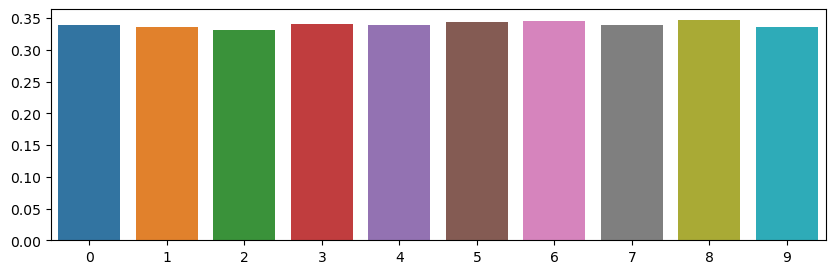

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
sns.barplot(x = list(range(len(rmses))), y = rmses)
plt.show()

### Question 6

* Split the dataset like previously, use seed 9.
* Combine train and validation datasets.
* Fill the missing values with 0 and train a model with `r=0.001`. 
* What's the RMSE on the test dataset?

Options:
- **0.35**
- 0.035
- 0.45
- 0.045

In [23]:
# split data with a seed
df_train, df_val, df_test, y_train, y_val, y_test = prepare_data(data, 9, 0.2, 0.2)
df_train_val, y_train_val = pd.concat([df_train, df_val]), np.concatenate([y_train, y_val])
model = train_linear_regression_w_reg(df_train_val, y_train_val, 0.001)

df_test = fill_missings(df_test)
y_pred = apply_the_model(df_test, model)
round(rmse(y_pred, y_test), 2)

0.35

In [25]:
from hashlib import sha1

def compute_hash(email):
    return sha1(email.lower().encode('utf-8')).hexdigest()

compute_hash('ksenia.legostay@gmail.com')

'32024a812c5fd3d14651ef4b50eac5ac24bccef0'